In [1]:

#Here come my imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Input, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Using this reference. Thank you, Jason Brownlee
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(55)
#Load data
month_df=pd.read_csv('monthly_energy_consumption.csv',index_col=[0])
month=month_df.values.astype('float32')
#scaling data
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(month)
#Splitting train and test: 2017 and 2018 will be test
test_size=len(month_df[month_df.index>='2017'])
train_size=int(len(dataset)-test_size)
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]
##making sure that I have numpy arrays to work with
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


# LSTM Network for Regression

In [3]:
look_back=1
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays. This is the most confusing part.
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) 

# create, compile and fit the LSTM network
model = Sequential()
model.add(Input(shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,validation_data=(testX, testY), shuffle=False)

Epoch 1/100
142/142 - 1s - 4ms/step - loss: 0.1873 - val_loss: 0.0501
Epoch 2/100
142/142 - 0s - 473us/step - loss: 0.0780 - val_loss: 0.0443
Epoch 3/100
142/142 - 0s - 479us/step - loss: 0.0508 - val_loss: 0.0516
Epoch 4/100
142/142 - 0s - 470us/step - loss: 0.0477 - val_loss: 0.0525
Epoch 5/100
142/142 - 0s - 464us/step - loss: 0.0470 - val_loss: 0.0521
Epoch 6/100
142/142 - 0s - 465us/step - loss: 0.0465 - val_loss: 0.0517
Epoch 7/100
142/142 - 0s - 466us/step - loss: 0.0462 - val_loss: 0.0513
Epoch 8/100
142/142 - 0s - 458us/step - loss: 0.0458 - val_loss: 0.0510
Epoch 9/100
142/142 - 0s - 463us/step - loss: 0.0455 - val_loss: 0.0507
Epoch 10/100
142/142 - 0s - 453us/step - loss: 0.0453 - val_loss: 0.0505
Epoch 11/100
142/142 - 0s - 466us/step - loss: 0.0450 - val_loss: 0.0503
Epoch 12/100
142/142 - 0s - 530us/step - loss: 0.0448 - val_loss: 0.0502
Epoch 13/100
142/142 - 0s - 472us/step - loss: 0.0447 - val_loss: 0.0501
Epoch 14/100
142/142 - 0s - 465us/step - loss: 0.0445 - val_lo

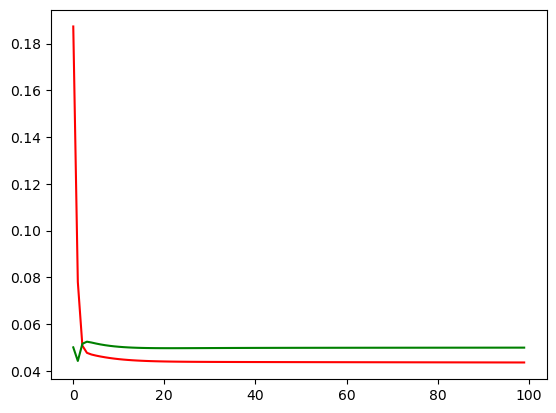

In [4]:
plt.plot(my_model.history['loss'],color='r');
plt.plot(my_model.history['val_loss'],color='g');

In [5]:
for a,b in enumerate(zip(my_model.history['loss'],my_model.history['val_loss'])):
    #print(b)
    if b[1]>b[0]:
        print(a+1, b)
        break


3 (0.05078841745853424, 0.051594078540802)


In [6]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
best_score=1_000_000_000
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 956900.08 RMSE
Test Score: 1027691.25 RMSE
We have a new winner: 1_027_691


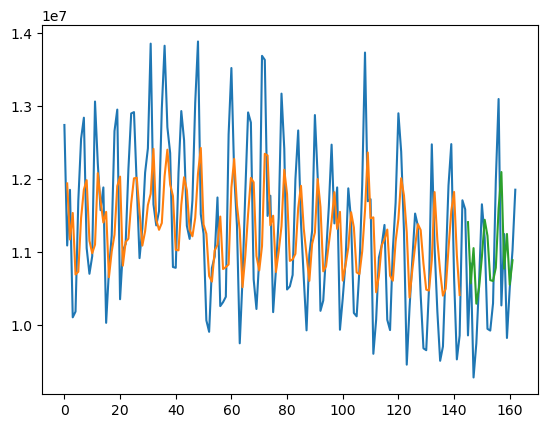

In [7]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Using Window Method


In [11]:
# It is about changing the lookback value up to 3
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) 
# create and fit the LSTM network
model = Sequential()
model.add(Input( shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,validation_data=(testX, testY))

Epoch 1/100
140/140 - 0s - 4ms/step - loss: 0.2322 - val_loss: 0.0724
Epoch 2/100
140/140 - 0s - 476us/step - loss: 0.1070 - val_loss: 0.0536
Epoch 3/100
140/140 - 0s - 468us/step - loss: 0.0714 - val_loss: 0.0595
Epoch 4/100
140/140 - 0s - 452us/step - loss: 0.0648 - val_loss: 0.0619
Epoch 5/100
140/140 - 0s - 453us/step - loss: 0.0620 - val_loss: 0.0619
Epoch 6/100
140/140 - 0s - 471us/step - loss: 0.0598 - val_loss: 0.0614
Epoch 7/100
140/140 - 0s - 465us/step - loss: 0.0580 - val_loss: 0.0607
Epoch 8/100
140/140 - 0s - 467us/step - loss: 0.0563 - val_loss: 0.0601
Epoch 9/100
140/140 - 0s - 457us/step - loss: 0.0548 - val_loss: 0.0594
Epoch 10/100
140/140 - 0s - 457us/step - loss: 0.0534 - val_loss: 0.0588
Epoch 11/100
140/140 - 0s - 467us/step - loss: 0.0521 - val_loss: 0.0582
Epoch 12/100
140/140 - 0s - 461us/step - loss: 0.0508 - val_loss: 0.0576
Epoch 13/100
140/140 - 0s - 643us/step - loss: 0.0495 - val_loss: 0.0569
Epoch 14/100
140/140 - 0s - 473us/step - loss: 0.0482 - val_lo

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_lookback_2 = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 806522.75 RMSE
Test Score: 1027691.25 RMSE
Nothing changed


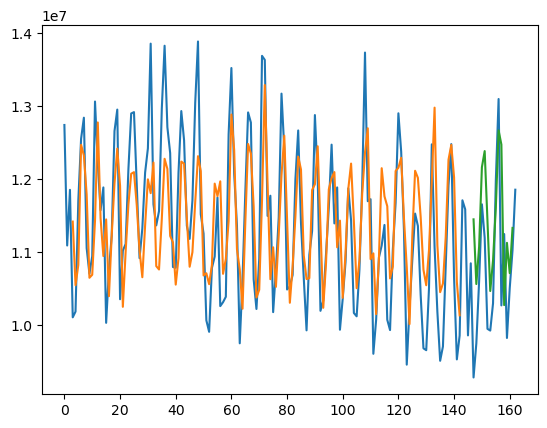

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Using Time steps

In [14]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

model = Sequential()
model.add(Input(shape=(look_back,1)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,validation_data=(testX, testY))

Epoch 1/100
140/140 - 1s - 4ms/step - loss: 0.1726 - val_loss: 0.0487
Epoch 2/100
140/140 - 0s - 707us/step - loss: 0.0675 - val_loss: 0.0633
Epoch 3/100
140/140 - 0s - 637us/step - loss: 0.0629 - val_loss: 0.0654
Epoch 4/100
140/140 - 0s - 610us/step - loss: 0.0619 - val_loss: 0.0652
Epoch 5/100
140/140 - 0s - 616us/step - loss: 0.0610 - val_loss: 0.0649
Epoch 6/100
140/140 - 0s - 641us/step - loss: 0.0600 - val_loss: 0.0647
Epoch 7/100
140/140 - 0s - 709us/step - loss: 0.0590 - val_loss: 0.0645
Epoch 8/100
140/140 - 0s - 783us/step - loss: 0.0580 - val_loss: 0.0643
Epoch 9/100
140/140 - 0s - 611us/step - loss: 0.0569 - val_loss: 0.0643
Epoch 10/100
140/140 - 0s - 597us/step - loss: 0.0557 - val_loss: 0.0643
Epoch 11/100
140/140 - 0s - 646us/step - loss: 0.0544 - val_loss: 0.0644
Epoch 12/100
140/140 - 0s - 615us/step - loss: 0.0530 - val_loss: 0.0646
Epoch 13/100
140/140 - 0s - 872us/step - loss: 0.0515 - val_loss: 0.0649
Epoch 14/100
140/140 - 0s - 598us/step - loss: 0.0500 - val_lo

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 834578.24 RMSE
Test Score: 1120003.50 RMSE
Nothing changed


## using Memory between batches or (stateful)

In [19]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True))  #We add stateful as True as we remember the previuos state
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2,validation_data=(testX, testY),shuffle=False)
    #model.reset_state()

140/140 - 1s - 5ms/step - loss: 0.1652 - val_loss: 0.0504
140/140 - 0s - 623us/step - loss: 0.0549 - val_loss: 0.0514
140/140 - 0s - 2ms/step - loss: 0.0528 - val_loss: 0.0507
140/140 - 0s - 655us/step - loss: 0.0520 - val_loss: 0.0500
140/140 - 0s - 635us/step - loss: 0.0513 - val_loss: 0.0493
140/140 - 0s - 632us/step - loss: 0.0507 - val_loss: 0.0486
140/140 - 0s - 617us/step - loss: 0.0501 - val_loss: 0.0478
140/140 - 0s - 622us/step - loss: 0.0495 - val_loss: 0.0471
140/140 - 0s - 616us/step - loss: 0.0489 - val_loss: 0.0463
140/140 - 0s - 613us/step - loss: 0.0483 - val_loss: 0.0455
140/140 - 0s - 659us/step - loss: 0.0476 - val_loss: 0.0447
140/140 - 0s - 631us/step - loss: 0.0470 - val_loss: 0.0440
140/140 - 0s - 637us/step - loss: 0.0463 - val_loss: 0.0433
140/140 - 0s - 819us/step - loss: 0.0456 - val_loss: 0.0427
140/140 - 0s - 646us/step - loss: 0.0449 - val_loss: 0.0422
140/140 - 0s - 678us/step - loss: 0.0443 - val_loss: 0.0418
140/140 - 0s - 638us/step - loss: 0.0436 - v

In [20]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
Train Score: 826422.56 RMSE
Test Score: 979415.28 RMSE
We have a new winner: 979_415


## Stacked LSTMs with Memory Between Batches

In [21]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True,return_sequences=True))
model.add(LSTM(4,stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2,validation_data=(testX, testY),shuffle=False)
    #model.reset_states()

140/140 - 1s - 6ms/step - loss: 0.1192 - val_loss: 0.0516
140/140 - 0s - 877us/step - loss: 0.0594 - val_loss: 0.0524
140/140 - 0s - 866us/step - loss: 0.0590 - val_loss: 0.0524
140/140 - 0s - 869us/step - loss: 0.0589 - val_loss: 0.0526
140/140 - 0s - 868us/step - loss: 0.0588 - val_loss: 0.0528
140/140 - 0s - 879us/step - loss: 0.0588 - val_loss: 0.0530
140/140 - 0s - 865us/step - loss: 0.0587 - val_loss: 0.0532
140/140 - 0s - 874us/step - loss: 0.0586 - val_loss: 0.0534
140/140 - 0s - 860us/step - loss: 0.0586 - val_loss: 0.0536
140/140 - 0s - 878us/step - loss: 0.0585 - val_loss: 0.0538
140/140 - 0s - 912us/step - loss: 0.0585 - val_loss: 0.0540
140/140 - 0s - 879us/step - loss: 0.0584 - val_loss: 0.0541
140/140 - 0s - 886us/step - loss: 0.0584 - val_loss: 0.0543
140/140 - 0s - 879us/step - loss: 0.0583 - val_loss: 0.0544
140/140 - 0s - 910us/step - loss: 0.0582 - val_loss: 0.0545
140/140 - 0s - 881us/step - loss: 0.0582 - val_loss: 0.0546
140/140 - 0s - 888us/step - loss: 0.0581 -

In [23]:
trainPredict = model.predict(trainX, batch_size=batch_size)
#model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
Train Score: 656212.00 RMSE
Test Score: 865981.88 RMSE
We have a new winner: 865_982


# MORE THINGS WITH LSTM
Combining things that work the best not to get the best forecast

In [26]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
print(trainX.shape)
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 
model=Sequential()
model.add(Input(shape=(trainX.shape[1],1)))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=10, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
my_model=model.fit(trainX, trainY, epochs=50,batch_size=32,verbose=2,validation_data=(testX, testY))

(140, 3, 1)
Epoch 1/50
5/5 - 1s - 184ms/step - loss: 0.2468 - val_loss: 0.1229
Epoch 2/50
5/5 - 0s - 4ms/step - loss: 0.2279 - val_loss: 0.1121
Epoch 3/50
5/5 - 0s - 4ms/step - loss: 0.2103 - val_loss: 0.1019
Epoch 4/50
5/5 - 0s - 4ms/step - loss: 0.1943 - val_loss: 0.0922
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.1768 - val_loss: 0.0832
Epoch 6/50
5/5 - 0s - 4ms/step - loss: 0.1588 - val_loss: 0.0751
Epoch 7/50
5/5 - 0s - 4ms/step - loss: 0.1450 - val_loss: 0.0681
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.1304 - val_loss: 0.0629
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.1171 - val_loss: 0.0601
Epoch 10/50
5/5 - 0s - 4ms/step - loss: 0.1071 - val_loss: 0.0600
Epoch 11/50
5/5 - 0s - 11ms/step - loss: 0.1034 - val_loss: 0.0620
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.1018 - val_loss: 0.0645
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.1010 - val_loss: 0.0657
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 0.0968 - val_loss: 0.0656
Epoch 15/50
5/5 - 0s - 4ms/step - loss: 0.0954 - val_loss: 0.0649
Epoc

In [27]:
trainPredict = model.predict(trainX)
#model.reset_states()
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict[:,0])
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict[:,0])
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 1264897.62 RMSE
Test Score: 1018784.09 RMSE
Nothing changed


In [44]:
results=pd.read_csv('scores.csv',index_col=0)
results.loc['LSTM']=best_score
results.sort_values('rmse').to_csv('scores.csv')
##LSTM got the thirsd position
results.sort_values('rmse')

,rmse
prophet,5.716658e+05
holt_winter,5.806893e+05
LSTM,8.659819e+05
holt_linear,9.384738e+05
moving_average,9.440476e+05
arima,9.494379e+05
SES,9.742467e+05
simple_average,1.122177e+06
naive,1.325609e+06
sarima,4.448724e+06
